In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
from glob import glob
import sklearn
import tensorflow as tf
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
DATA_DIR = "./input/A_DeviceMotion_data/"
print(os.listdir(DATA_DIR))

# Any results you write to the current directory are saved as output.

['dws_1', 'dws_11', 'dws_2', 'jog_16', 'jog_9', 'sit_13', 'sit_5', 'std_14', 'std_6', 'ups_12', 'ups_3', 'ups_4', 'wlk_15', 'wlk_7', 'wlk_8']


In [3]:
import seq_stat


In [5]:
get_seq_feat = seq_stat.seq_stat

In [6]:
# Activety types dict:
Activety_Types = {'dws':1,'jog':2,'sit':3,'std':4,'ups':5,'wlk':6}        
listDict = list(Activety_Types.keys())


In [7]:
# Data Folders:
Folders = glob(DATA_DIR + '*_*')
Folders = [s for s in Folders if "csv" not in s]

Df_all_list = []
Exp = 0
# Segment the data to 400 sampels frames , each one will be a different Expirament
Segment_Size = 400

# Load All data:
for j  in Folders:
    Csv = glob(j + '/*' )


    for i in Csv:
        df = pd.read_csv(i)
        # Add Activety label, Subject name and Experiment number
        df['Activity'] = Activety_Types[j[28:31]]
        df['Sub_Num'] = i[len(j)+5:-4]
        df['Exp_num'] = 1
        ExpNum = np.zeros((df.shape[0])) 
        for i in range(0,df.shape[0]-Segment_Size,Segment_Size):
            ExpNum[range(i,i+Segment_Size)] = i/Segment_Size +Exp*100 
        df['Exp_num'] = ExpNum
        #Df_all = pd.concat([Df_all,df])
        Df_all_list.append(df)
        Exp += 1        

Df_all = pd.concat(Df_all_list,axis=0)  

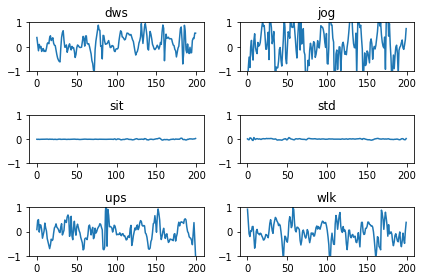

In [8]:
# let's see the data
Df_all.head()
plt.plot([1,2,3])
# now create a subplot which represents the top plot of a grid
# with 2 rows and 1 column. Since this subplot will overlap the
# first, the plot (and its axes) previously created, will be removed
#plt.subplot(2,1,1)
#plt.plot(range(12))
for i in range(6):
    D = Df_all[Df_all['Activity']==i+1]
    plt.subplot(3,2,i+1)
    plt.plot(D['userAcceleration.z'][:200])
    plt.title(listDict[i])
    plt.ylim([-1, 1])
plt.tight_layout()


In [9]:
def cross(series, cross=0, direction='cross'):
    """
    Given a Series returns all the index values where the data values equal 
    the 'cross' value. 

    Direction can be 'rising' (for rising edge), 'falling' (for only falling 
    edge), or 'cross' for both edges
    """
    # Find if values are above or bellow yvalue crossing:
    above=series.values > cross
    below=np.logical_not(above)
    left_shifted_above = above[1:]
    left_shifted_below = below[1:]
    x_crossings = []
    # Find indexes on left side of crossing point
    if direction == 'rising':
        idxs = (left_shifted_above & below[0:-1]).nonzero()[0]
    elif direction == 'falling':
        idxs = (left_shifted_below & above[0:-1]).nonzero()[0]
    else:
        rising = left_shifted_above & below[0:-1]
        falling = left_shifted_below & above[0:-1]
        idxs = (rising | falling).nonzero()[0]

    # Calculate x crossings with interpolation using formula for a line:
    x1 = series.index.values[idxs]
    x2 = series.index.values[idxs+1]
    y1 = series.values[idxs]
    y2 = series.values[idxs+1]
    x_crossings = (cross-y1)*(x2-x1)/(y2-y1) + x1

    return x_crossings

In [10]:
#  Calculate features
df_sum = Df_all.groupby('Exp_num', axis=0).mean().reset_index()
df_sum.columns = df_sum.columns.str.replace('.','_sum_')

df_sum_SS = np.power(Df_all.astype(float),2).groupby('Exp_num', axis=0).median().reset_index() 
df_sum_SS.columns = df_sum_SS.columns.str.replace('.','_sumSS_')

df_max = Df_all.groupby('Exp_num', axis=0).max().reset_index()
df_max.columns = df_max.columns.str.replace('.','_max_')

df_min = Df_all.groupby('Exp_num', axis=0).min().reset_index()
df_min.columns = df_min.columns.str.replace('.','_min_')

df_skew = Df_all.groupby('Exp_num', axis=0).skew().reset_index()
df_skew.columns = df_skew.columns.str.replace('.','_skew_')

df_std = Df_all.groupby('Exp_num', axis=0).std().reset_index()
df_std.columns = df_std.columns.str.replace('.','_std_')

#df_kurt = Df_all.groupby('Exp_num', axis=0).apply(pd.DataFrame.kurt)
#df_kurt.columns = df_kurt.columns.str.replace('.','_kurt_')

#df_zcross = Df_all.groupby('Exp_num', axis=0).apply(cross)
#df_zcross.columns = df_zcross.columns.str.replace('.','_zcross_')

In [11]:
# Concat features and labels vector into one Data Frame:
Df_Features = pd.concat([ df_max , df_sum[df_sum.columns[2:-2]], 
                         df_min[df_min.columns[2:-2]], df_sum_SS[df_sum_SS.columns[2:-2]], 
                         df_std[df_std.columns[2:-2]], df_skew[df_skew.columns[2:-2]]], axis=1)
                         #df_kurt[df_kurt.columns[2:-2]]], axis=1)
# Features
Df_Features_1 = Df_Features.drop(['Exp_num','Unnamed: 0','Activity','Sub_Num'],axis=1)
Labels = Df_Features['Activity']

In [12]:
len(Df_Features.columns)

74

In [13]:
# Train test split (this can be done also by user, to makeit a more realistic case)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Df_Features_1, Labels, test_size=0.25, random_state=42)

In [14]:
# Define placeholders for X and Y
X_shape = Df_Features_1.shape[1]
Class_Num = len(Activety_Types)
X = tf.placeholder(dtype=tf.float32,shape=[None,X_shape])
y = tf.placeholder(dtype=tf.float32,shape = [None,Class_Num])
Hold_prob = tf.placeholder(tf.float32)

In [16]:
# Helper functions for DNN design
def Init_Wightes(shape1):
    W = tf.truncated_normal(shape1,stddev=0.1)
    return tf.Variable(W)

def Init_bias(shape1):
    b =  tf.constant(0.1,shape=shape1)
    return tf.Variable(b)

def FC_layer(input1,shape1):
    
    W = Init_Wightes(shape1)
    B = Init_bias([shape1[1]])
    Wx = tf.matmul(input1,W)
    Wx_b = tf.add(Wx,B)
    return tf.nn.relu(Wx_b)

    

In [18]:
# Define model parmeters and net design
H1_size = 54
H2_size = 24

H1 = FC_layer(X, [X_shape,H1_size])
#H2 = FC_layer(H1,[H1_size,H2_size])
H1_drop = tf.nn.dropout(H1,keep_prob=Hold_prob)
y_pred = FC_layer(H1_drop,[H1_size,len(Activety_Types)])

In [19]:
# Set TensorFlow Error and train function
Err = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=y_pred))
Optimaizer = tf.train.AdamOptimizer()
Train = Optimaizer.minimize(Err)
Init = tf.global_variables_initializer()




In [20]:
Y_test_Np

NameError: name 'Y_test_Np' is not defined

In [21]:
BatchSize = 64
label_binarizer = sklearn.preprocessing.LabelBinarizer()
label_binarizer.fit(range(Class_Num))

# convarte to numpy and devide into batches:

X_train_Np = np.array(X_train,dtype=np.float32)
Y_train_Np = np.array(y_train,dtype=np.float32)
X_test_Np = np.array(X_test,dtype=np.float32)
Y_test_Np = np.array(y_test,dtype=np.float32)
Y_test_OH  = label_binarizer.transform(Y_test_Np)
Y_test_OH = np.array(Y_test_OH,dtype=np.float32)
Batches = np.array(range(0,X_train_Np.shape[0]-BatchSize,BatchSize))


In [22]:
# Run net
steps = 5000

with tf.Session() as sess:
    
    sess.run(Init)
    
    for i in range(steps):
        
        BastchNum = np.mod(i,len(Batches)-1)
        #print(BastchNum)
        batch_x = X_train_Np[Batches[BastchNum] : Batches[BastchNum+1] ,:].astype(np.float32)
        batch_y = Y_train_Np[Batches[BastchNum] : Batches[BastchNum+1] ].astype(np.float32)
        batch_y_OH  = label_binarizer.transform(batch_y).astype(np.float32)
        batch_y_OH = np.array(batch_y_OH,dtype=np.float32)
        sess.run(Train,feed_dict={X:batch_x,y:batch_y_OH,Hold_prob:0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={X:X_test_Np,y:Y_test_OH,Hold_prob:1.0}))
            print('\n')
            Conf = tf.confusion_matrix(tf.arg_max(y_pred,1),tf.arg_max(y,1))
            C1 = sess.run(Conf,feed_dict={X:X_test_Np,y:Y_test_OH,Hold_prob:1.0})

Currently on step 0
Accuracy is:
0.21904762


Instructions for updating:
Use `argmax` instead
Currently on step 100
Accuracy is:
0.6261905


Currently on step 200
Accuracy is:
0.6654762


Currently on step 300
Accuracy is:
0.6869048


Currently on step 400
Accuracy is:
0.72261906


Currently on step 500
Accuracy is:
0.7892857


Currently on step 600
Accuracy is:
0.7892857


Currently on step 700
Accuracy is:
0.8535714


Currently on step 800
Accuracy is:
0.8130952


Currently on step 900
Accuracy is:
0.85238093


Currently on step 1000
Accuracy is:
0.90119046


Currently on step 1100
Accuracy is:
0.88214284


Currently on step 1200
Accuracy is:
0.9190476


Currently on step 1300
Accuracy is:
0.93333334


Currently on step 1400
Accuracy is:
0.9357143


Currently on step 1500
Accuracy is:
0.94285715


Currently on step 1600
Accuracy is:
0.9511905


Currently on step 1700
Accuracy is:
0.94285715


Currently on step 1800
Accuracy is:
0.9559524


Currently on step 1900
Accuracy is:
0.955952

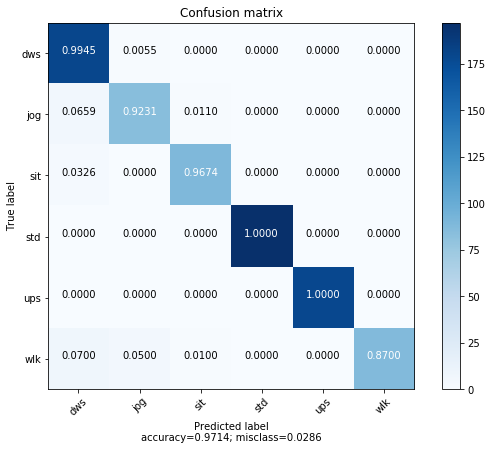

In [57]:
# Plot Confusion matrix
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()
    
   
Conf = tf.confusion_matrix(tf.arg_max(y_pred,1),tf.arg_max(y,1))
#Conf = tf.confusion_matrix(prediction,tf.arg_max(y,1))
plot_confusion_matrix(C1,target_names=[*Activety_Types])



In [24]:
a = Df_all[Df_all['Exp_num'] == 0]

In [25]:
Df_all.columns

Index(['Unnamed: 0', 'attitude.roll', 'attitude.pitch', 'attitude.yaw',
       'gravity.x', 'gravity.y', 'gravity.z', 'rotationRate.x',
       'rotationRate.y', 'rotationRate.z', 'userAcceleration.x',
       'userAcceleration.y', 'userAcceleration.z', 'Activity', 'Sub_Num',
       'Exp_num'],
      dtype='object')

In [26]:
b = np.array(a)[...,1:-3]

In [27]:
SSS = seq_stat.seq_stat

In [28]:
b4 = b[:400, ...]

In [41]:
a = SSS(b4[:,3].astype(np.float32),400)


In [238]:
X_train, X_test, y_train, y_test

(      attitude_max_roll  attitude_max_pitch  attitude_max_yaw  gravity_max_x  \
 2033           1.072731           -1.259783          0.214753       0.266313   
 350            3.134470           -1.056001          0.212826       0.305506   
 3024           2.890145           -1.167150          3.136079       0.212181   
 2059          -2.710812           -1.393179         -2.746643      -0.025430   
 1330          -2.701470           -0.396408          0.343993      -0.384140   
 2630           1.928730           -0.800947          1.469254       0.257829   
 1106          -2.515832           -0.426361          0.748035      -0.475547   
 2596           1.614259           -0.548162          0.758891       0.624715   
 651           -2.920972           -0.135661         -1.277520      -0.210878   
 3015           0.254522           -0.944141          3.073848       0.055837   
 1037          -2.401960           -0.233860          0.962571      -0.653304   
 1694          -1.619975    

In [46]:
y_train.shape

(2519,)

In [47]:
from sklearn import svm

In [168]:
def one_hot_label(y, cls):
    sz = y.shape[0]
    retval = np.zeros((sz,cls))
    retval[list(range(sz)),y] = 1
    return retval

In [169]:
yyy = np.array([1, 2, 3, 0, 4, 5])
yyyone = one_hot_label(yyy, 6)

In [173]:
np.unique(y_train)

array([1, 2, 3, 4, 5, 6], dtype=int64)

## Example for raw model prediction with rbf kernel

In [708]:
x = [[1,2],[-1,0.4],[1.2,0.4],[2,4],[-2.5, 6],[-0.2,-0.5],[-2.5,-3.4]]
y = [0,1,0,0,1,2,2]


In [709]:
model = svm.SVC(decision_function_shape='ovo', kernel='linear')
model.fit(x,y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [710]:
model.predict(x)

array([0, 1, 0, 0, 1, 2, 2])

In [711]:
model.decision_function(x)

array([[ 1.00027436,  1.83754511,  0.56500001],
       [-0.99972567, -1.22382672,  0.72500001],
       [ 0.99945129,  0.99999999, -1.03499999],
       [ 2.13719919,  4.14801442,  1.56500001],
       [-1.72381836,  0.89891695,  6.96500001],
       [-0.37544585, -1.00000001, -0.72499999],
       [-2.79639614, -5.20938628, -1.49499999]])

In [712]:
model.n_support_

array([2, 1, 1])

In [713]:
model.support_vectors_

array([[ 1. ,  2. ],
       [ 1.2,  0.4],
       [-1. ,  0.4],
       [-0.2, -0.5]])

In [714]:
model.dual_coef_.shape

(2, 4)

In [715]:
model.coef_.shape

(3, 2)

In [716]:
model.n_support_

array([2, 1, 1])

In [717]:
a = _svm(model,3)
b = a.pred(np.array([1,2]))
print(b[0])
print(b[1])
print(b[2])


TypeError: linear() takes 1 positional argument but 2 were given

In [678]:
testx= np.array([1,2])

In [679]:
testx * testx

array([1, 4])

In [662]:
aa = model.decision_function(testx)

In [663]:
bb = model.predict(testx)

In [664]:
aa

array([[1.00027436, 1.83754511, 0.56500001]])

In [609]:
bb

array([0])

In [610]:
b

(0, (array([1.10805754, 1.14350947, 0.03573419]), array([[0., 1.],
         [0., 2.],
         [1., 2.]])), array([2., 1., 0.]))

In [536]:
model.kernel

'rbf'

In [653]:
help(svm.SVC)

Help on class SVC in module sklearn.svm.classes:

class SVC(sklearn.svm.base.BaseSVC)
 |  C-Support Vector Classification.
 |  
 |  The implementation is based on libsvm. The fit time scales at least
 |  quadratically with the number of samples and may be impractical
 |  beyond tens of thousands of samples. For large datasets
 |  consider using :class:`sklearn.linear_model.LinearSVC` or
 |  :class:`sklearn.linear_model.SGDClassifier` instead, possibly after a
 |  :class:`sklearn.kernel_approximation.Nystroem` transformer.
 |  
 |  The multiclass support is handled according to a one-vs-one scheme.
 |  
 |  For details on the precise mathematical formulation of the provided
 |  kernel functions and how `gamma`, `coef0` and `degree` affect each
 |  other, see the corresponding section in the narrative documentation:
 |  :ref:`svm_kernels`.
 |  
 |  Read more in the :ref:`User Guide <svm_classification>`.
 |  
 |  Parameters
 |  ----------
 |  C : float, optional (default=1.0)
 |      Pen

In [632]:
model = svm.SVC(kernel='linear',decision_function_shape='ovo') #select the algorithm
model.fit(X_train,y_train) # we train the algorithm with the training data and the training output
#y_train_OH = one_hot_label(y_train-1,6)
#model.fit(X_train,y_train_OH)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovo', degree=3, gamma=0.014285714285714285,
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [633]:
prediction=model.predict(X_test)

In [634]:
res = prediction == y_test

In [635]:
print("acc : {}".format(np.sum(res) / res.shape[0]))

acc : 0.9702380952380952


In [636]:
model.support_vectors_.shape

(300, 70)

In [637]:
model.support_.shape

(300,)

In [638]:
model.C

1.0

In [639]:
model.n_support_

array([63, 38, 29, 35, 56, 79])

In [640]:
model.dual_coef_.shape

(5, 300)

In [641]:
model.intercept_.shape

(15,)

In [642]:
np.dot([1,2],[3,4])

11

In [707]:

def rbft(sigma):
    return lambda x, y: np.exp(-np.sqrt(np.linalp.norm(x-y) ** 2 / (2 * sigma ** 2)))
def rbf(sigma):
    def rbf_k(x, y):
        print(x.shape, y.shape)
        x_y = (x - y)
        res = np.sum(x_y * x_y)
        #xy = (x * y)
        #xx = x * x
        #yy = y * y
        #xy = -2 * xy 
        return np.exp(- (sigma)  * res)
    return rbf_k
def linear(coef):
    def linear_k(x, y, p):
        return np.sum(x * y * coef[p,:])
    return linear_k

In [696]:
a.model.coef_.shape

(3, 2)

In [697]:
class _svm:
    __slots__ = ('model', 'gamma', 'kernel', 'ncls')
    def __init__(self, model, ncls, kernel='rbf', gamma=1/70):
        self.model = model
        self.gamma = gamma
        if kernel == 'rbf':
            self.kernel = rbf(gamma)
        elif kernel == 'linear':
            self.kernel = linear(self.coef_)
        self.ncls = ncls
    
    def pred(self, x):
        """TODO: linear kernel"""
        nr_cls = self.ncls
        l, feat_num = self.model.support_vectors_.shape
        kvalue = np.empty((l),dtype=np.float32)
        total_svm = int(nr_cls * (nr_cls-1)/2)
        retval = np.empty((total_svm),np.float32)

        for i in range(l):
            kvalue[i] = self.kernel(x, self.model.support_vectors_[i,:])
        start = np.empty((nr_cls), dtype=np.int32)
        start[0] = 0
        for i in range(1,nr_cls):
            start[i] = start[i-1] + self.model.n_support_[i-1]
        vote = np.zeros((nr_cls))
        p = 0
        pair = np.zeros((total_svm,2))
        for i in range(nr_cls):
            for j in range(i+1, nr_cls):
                _sum = 0
                si = start[i]
                sj = start[j]
                ci = self.model.n_support_[i]
                cj = self.model.n_support_[j]
                coef1 = self.model.dual_coef_[j-1,:]
                coef2 = self.model.dual_coef_[i,:]
                for k in range(ci):
                    _sum += coef1[si+k] * kvalue[si+k]
                for k in range(cj):
                    _sum += coef2[sj+k] * kvalue[sj+k]
                _sum -= self.model.intercept_[p]
                retval[p] = _sum
                if (retval[p] > 0):
                    vote[i] += 1
                else:
                    vote[j] += 1
                pair[p,0] = i
                pair[p,1] = j
                p += 1
        
        vote_max_idx = 0
        for i in range(1, nr_cls):
            if (vote[i] > vote[vote_max_idx]):
                vote_max_idx = i
        return (vote_max_idx, (retval,pair), vote)

        

In [673]:
a = _svm(model,6,kernel='linear')

In [676]:
res, retval, vote = a.pred(X_test.values[0,...])

ValueError: operands could not be broadcast together with shapes (70,) (2,) 

In [675]:
vote

array([2., 5., 0., 1., 3., 4.])

In [649]:
np.hstack((retval[0].reshape(15,1), retval[1]))

array([[-2.59851003,  0.        ,  1.        ],
       [ 1.90568769,  0.        ,  2.        ],
       [ 0.71598876,  0.        ,  3.        ],
       [-2.06388044,  0.        ,  4.        ],
       [-1.50646603,  0.        ,  5.        ],
       [ 1.58923316,  1.        ,  2.        ],
       [ 1.50543654,  1.        ,  3.        ],
       [ 4.83700323,  1.        ,  4.        ],
       [ 6.14228678,  1.        ,  5.        ],
       [-8.46578789,  2.        ,  3.        ],
       [-1.64729822,  2.        ,  4.        ],
       [-2.27787256,  2.        ,  5.        ],
       [-2.27709675,  3.        ,  4.        ],
       [-0.62299192,  3.        ,  5.        ],
       [-3.73646069,  4.        ,  5.        ]])

In [650]:
scores = model.decision_function(X_test.values[0:1,...])

In [651]:
scores

array([[ 2.83396229, -1.69959135, -3.28832021,  1.58348811, -2.14676002,
        -1.53106975, -1.63231555, -2.39678431, -6.55307761,  1.45160837,
         1.90420365,  2.0040662 ,  5.39402553,  3.14575752, -4.50198771]])

In [652]:
retval[0]

array([-2.59851   ,  1.9056877 ,  0.71598876, -2.0638804 , -1.506466  ,
        1.5892332 ,  1.5054365 ,  4.837003  ,  6.142287  , -8.465788  ,
       -1.6472982 , -2.2778726 , -2.2770967 , -0.6229919 , -3.7364607 ],
      dtype=float32)

In [430]:
model.predict(X_test.values[0:1,...])

array([3], dtype=int64)

In [103]:
s


['C',
 '__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_cache',
 '_abc_negative_cache',
 '_abc_negative_cache_version',
 '_abc_registry',
 '_check_proba',
 '_compute_kernel',
 '_decision_function',
 '_dense_decision_function',
 '_dense_fit',
 '_dense_predict',
 '_dense_predict_proba',
 '_dual_coef_',
 '_estimator_type',
 '_gamma',
 '_get_coef',
 '_get_param_names',
 '_get_tags',
 '_impl',
 '_intercept_',
 '_pairwise',
 '_predict_log_proba',
 '_predict_proba',
 '_sparse',
 '_sparse_decision_function',
 '_sparse_fit',
 '_sparse_kernels',
 '_sparse_predict',
 '_sparse_predict_proba',
 '_validate_for_predict',
 

support_ : array-like, shape = [n_SV]
Indices of support vectors.

support_vectors_ : array-like, shape = [n_SV, n_features]
Support vectors.

n_support_ : array-like, dtype=int32, shape = [n_class]
Number of support vectors for each class.

dual_coef_ : array, shape = [n_class-1, n_SV]
Coefficients of the support vector in the decision function. For multiclass, coefficient for all 1-vs-1 classifiers. The layout of the coefficients in the multiclass case is somewhat non-trivial. See the section about multi-class classification in the SVM section of the User Guide for details.

coef_ : array, shape = [n_class * (n_class-1) / 2, n_features]
Weights assigned to the features (coefficients in the primal problem). This is only available in the case of a linear kernel.

coef_ is a readonly property derived from dual_coef_ and support_vectors_.

intercept_ : array, shape = [n_class * (n_class-1) / 2]
Constants in decision function.

fit_status_ : int
0 if correctly fitted, 1 otherwise (will raise warning)

probA_ : array, shape = [n_class * (n_class-1) / 2]
probB_ : array, shape = [n_class * (n_class-1) / 2]
If probability=True, the parameters learned in Platt scaling to produce probability estimates from decision values. If probability=False, an empty array. Platt scaling uses the logistic function 1 / (1 + exp(decision_value * probA_ + probB_)) where probA_ and probB_ are learned from the dataset [R20c70293ef72-2]. For more information on the multiclass case and training procedure see section 8 of [R20c70293ef72-1].